# Análisis de Integración de Sentimiento para Predicción de Bitcoin
Este notebook plantea un análisis desde cero para determinar si los datos de sentimiento pueden mejorar el modelo técnico desarrollado anteriormente

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Configuración para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

In [14]:
# ------------------------------
# 1. Cargar y Preparar los Datos
# ------------------------------
# 1.1 Cargar datos técnicos y de sentimiento

print("\n## 1. Carga de Datos")
print("-" * 50)

print("Cargando datasets...")

# Cargar el dataset técnico
df_tecnico = pd.read_csv('btc_nextday_prediction_data.csv', index_col=0, parse_dates=True)
print(f"Dataset técnico cargado: {df_tecnico.shape} filas, {df_tecnico.shape[1]} columnas")

# Cargar el dataset de sentimiento
df_sentimiento = pd.read_parquet('df_news_sentiment.parquet', engine='fastparquet')
print(f"Dataset de sentimiento cargado: {df_sentimiento.shape} filas, {df_sentimiento.shape[1]} columnas")

# Asegurar que ambos dataframes tienen el índice temporal correctamente configurado
df_tecnico.index.name = 'date'
df_sentimiento.index.name = 'date'

# Verificar el rango de fechas de ambos datasets
print("\nRango de fechas del dataset técnico:", df_tecnico.index.min(), "a", df_tecnico.index.max())
print("Rango de fechas del dataset de sentimiento:", df_sentimiento.index.min(), "a", df_sentimiento.index.max())

# Verificar días en común
dias_comunes = df_tecnico.index.intersection(df_sentimiento.index)
print(f"Días en común: {len(dias_comunes)} de {len(df_tecnico)} ({len(dias_comunes)/len(df_tecnico)*100:.1f}%)")



## 1. Carga de Datos
--------------------------------------------------
Cargando datasets...
Dataset técnico cargado: (262, 11) filas, 11 columnas
Dataset de sentimiento cargado: (262, 6) filas, 6 columnas

Rango de fechas del dataset técnico: 2024-01-01 00:00:00 a 2024-12-31 00:00:00
Rango de fechas del dataset de sentimiento: 2024-01-01 00:00:00 a 2024-12-31 00:00:00
Días en común: 262 de 262 (100.0%)



## 2. Exploración del Dataset de Sentimiento
--------------------------------------------------

Primeras filas del dataset de sentimiento:
                                                       titles  \
date                                                            
2024-01-01  [Bitcoin price surges above $45,000 for first ...   
2024-01-02  [The hullabaloo over crypto has quietened desp...   
2024-01-03  [Biggest stock movers today: Crypto stocks, So...   
2024-01-04  [Bitcoin price in Saudi Arabia on January 4, 2...   
2024-01-05  [Elon Musk drops price of X gold checks amid r...   

                                                         urls  \
date                                                            
2024-01-01  [https://www.livemint.com/market/cryptocurrenc...   
2024-01-02  [https://www.livemint.com/opinion/online-views...   
2024-01-03  [https://seekingalpha.com/news/4051785-biggest...   
2024-01-04  [https://www.bolnews.com/business/2024/01/btc-...   
2024-01-05  [

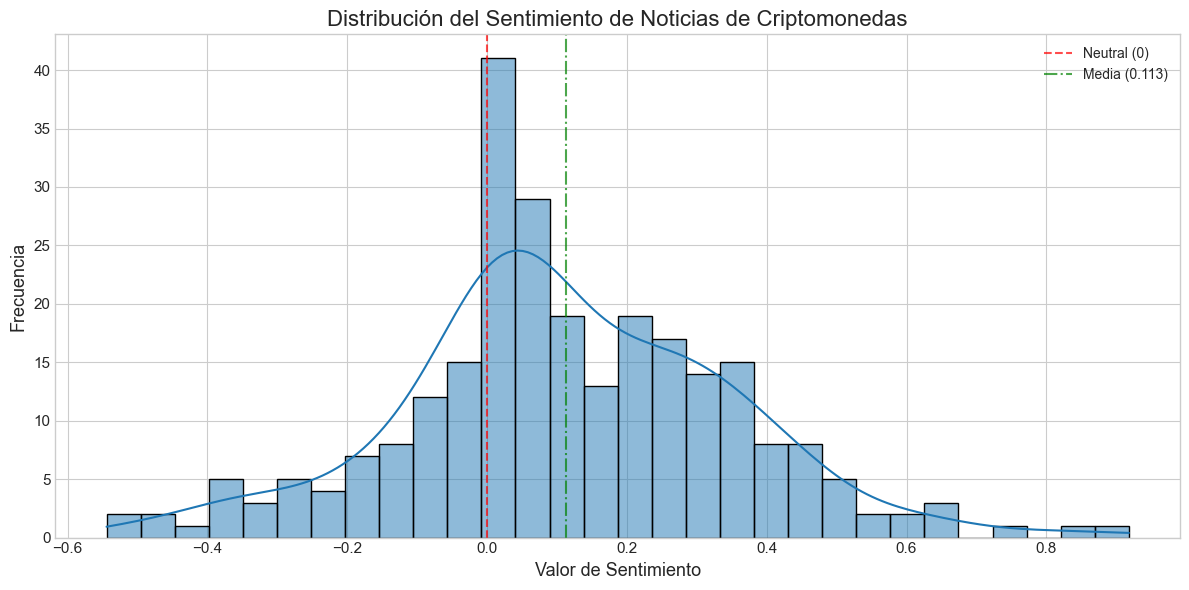

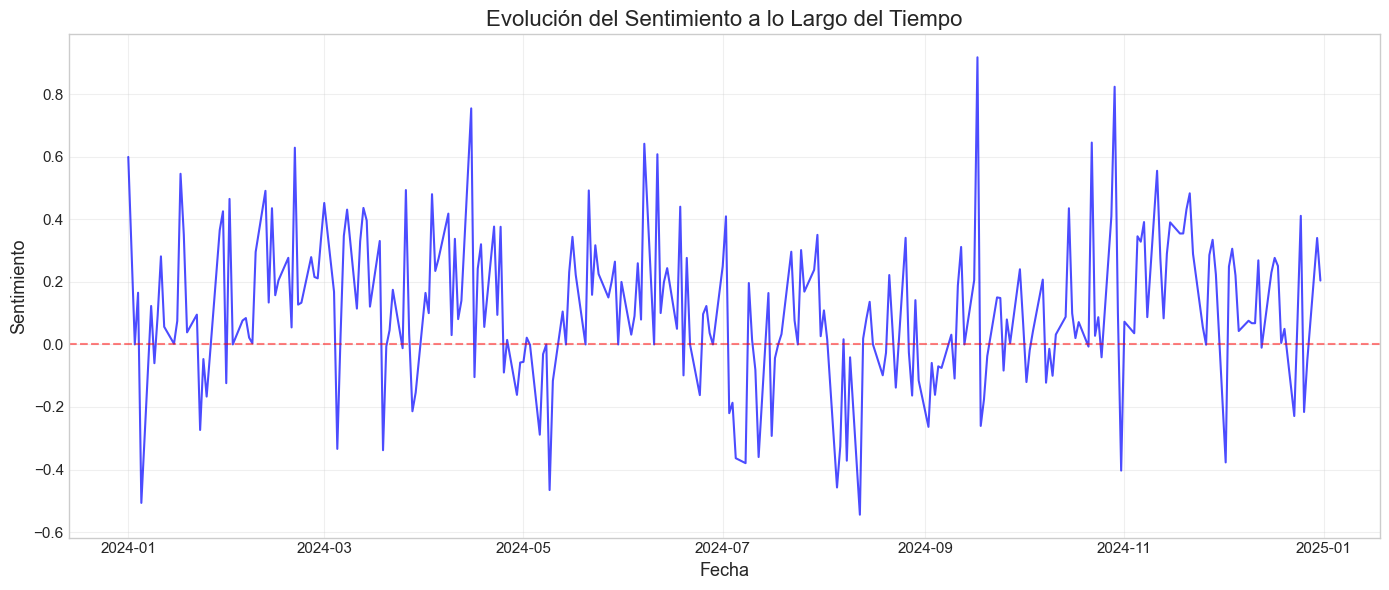

In [15]:
# ------------------------------
# 2. Exploración del Dataset de Sentimiento
# ------------------------------
print("\n## 2. Exploración del Dataset de Sentimiento")
print("-" * 50)

# Mostrar primeras filas del dataset de sentimiento
print("\nPrimeras filas del dataset de sentimiento:")
print(df_sentimiento.head())

# Verificar columnas disponibles
print("\nColumnas en el dataset de sentimiento:")
print(df_sentimiento.columns.tolist())

# Estadísticas descriptivas del sentimiento
sentimiento = df_sentimiento['mean_sentiment'].copy()
print("\nEstadísticas descriptivas del sentimiento:")
print(sentimiento.describe())

# Valores faltantes
missing_count = sentimiento.isna().sum()
print(f"\nValores faltantes en sentimiento: {missing_count} de {len(sentimiento)} ({missing_count/len(sentimiento)*100:.1f}%)")

# Imputar valores faltantes con 0 (sentimiento neutral)
sentimiento = sentimiento.fillna(0)

# Visualización 1: Distribución del sentimiento
plt.figure(figsize=(12, 6))
sns.histplot(sentimiento, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Neutral (0)')
plt.axvline(x=sentimiento.mean(), color='g', linestyle='-.', alpha=0.7, label=f'Media ({sentimiento.mean():.3f})')
plt.title('Distribución del Sentimiento de Noticias de Criptomonedas')
plt.xlabel('Valor de Sentimiento')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

# Visualización 2: Evolución temporal del sentimiento
plt.figure(figsize=(14, 6))
plt.plot(sentimiento.index, sentimiento, color='blue', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Evolución del Sentimiento a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Sentimiento')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## 3. Análisis de la Relación entre Sentimiento y Precio
--------------------------------------------------
Variable objetivo cargada: 131 días de subida de un total de 262
Distribución: 50.0% días de subida, 50.0% días de bajada

Correlación directa entre sentimiento y dirección del precio del día siguiente: -0.0108


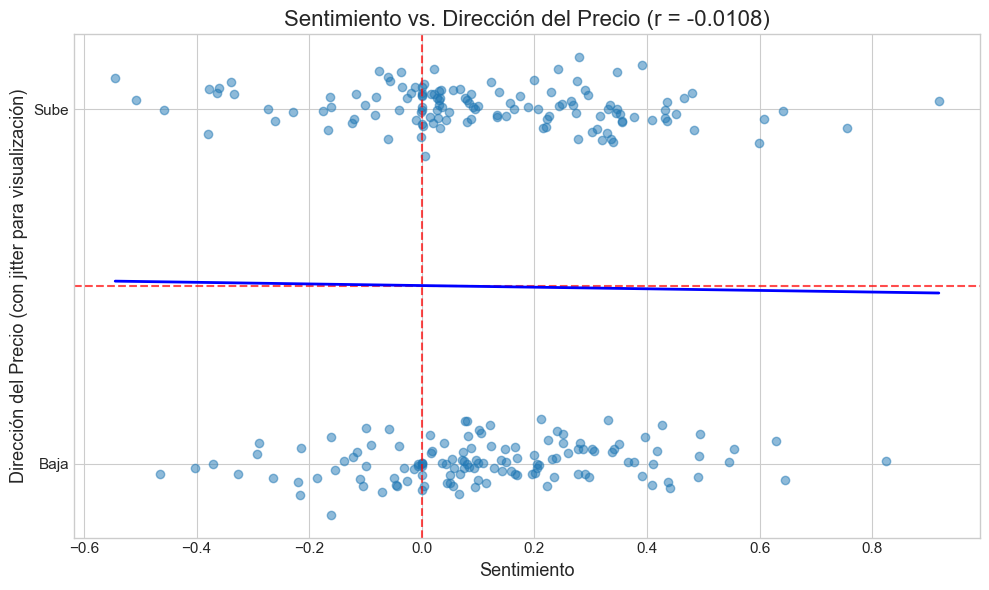

In [16]:
# ------------------------------
# 3. Análisis de la Relación entre Sentimiento y Precio
# ------------------------------
print("\n## 3. Análisis de la Relación entre Sentimiento y Precio")
print("-" * 50)

# Crear DataFrame temporal para análisis, uniendo sentimiento y target
df_analisis = pd.DataFrame(index=df_tecnico.index)

# Añadir target
if 'target_nextday' in df_tecnico.columns:
    df_analisis['target_nextday'] = df_tecnico['target_nextday']
    print(f"Variable objetivo cargada: {df_analisis['target_nextday'].sum()} días de subida de un total de {len(df_analisis)}")
    print(f"Distribución: {df_analisis['target_nextday'].mean()*100:.1f}% días de subida, {(1-df_analisis['target_nextday'].mean())*100:.1f}% días de bajada")
else:
    print("¡ADVERTENCIA! No se encontró la variable objetivo 'target_nextday' en el dataset técnico.")
    print("El análisis de relación con el precio no será posible.")

# Añadir sentimiento
df_analisis['mean_sentiment'] = sentimiento.reindex(df_analisis.index).fillna(0)

# Calcular correlación directa
if 'target_nextday' in df_analisis.columns:
    corr_directa = df_analisis['mean_sentiment'].corr(df_analisis['target_nextday'])
    print(f"\nCorrelación directa entre sentimiento y dirección del precio del día siguiente: {corr_directa:.4f}")

    # Visualización 3: Diagrama de dispersión de sentimiento vs. target
    plt.figure(figsize=(10, 6))
    
    # Agregar ruido aleatorio pequeño al target para visualización
    jittered_target = df_analisis['target_nextday'] + np.random.normal(0, 0.05, size=len(df_analisis))
    
    plt.scatter(df_analisis['mean_sentiment'], jittered_target, alpha=0.5)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
    
    # Añadir línea de tendencia
    z = np.polyfit(df_analisis['mean_sentiment'], df_analisis['target_nextday'], 1)
    p = np.poly1d(z)
    plt.plot(np.sort(df_analisis['mean_sentiment']), p(np.sort(df_analisis['mean_sentiment'])), 
             color='blue', linestyle='-', linewidth=2)
    
    plt.title(f'Sentimiento vs. Dirección del Precio (r = {corr_directa:.4f})')
    plt.xlabel('Sentimiento')
    plt.ylabel('Dirección del Precio (con jitter para visualización)')
    plt.yticks([0, 1], ['Baja', 'Sube'])
    plt.tight_layout()
    plt.show()


## 4. Análisis por Quintiles de Sentimiento
--------------------------------------------------

Probabilidad de subida por quintil de sentimiento:
             mean  count  diff_from_avg
sent_q                                 
0       49.056604     53      -0.943396
1       65.384615     52      15.384615
2       32.692308     52     -17.307692
3       46.153846     52      -3.846154
4       56.603774     53       6.603774

Quintil con mayor probabilidad de subida: Q2 (65.4%)
Quintil con menor probabilidad de subida: Q3 (32.7%)
Diferencia entre quintiles extremos: 32.7 puntos porcentuales


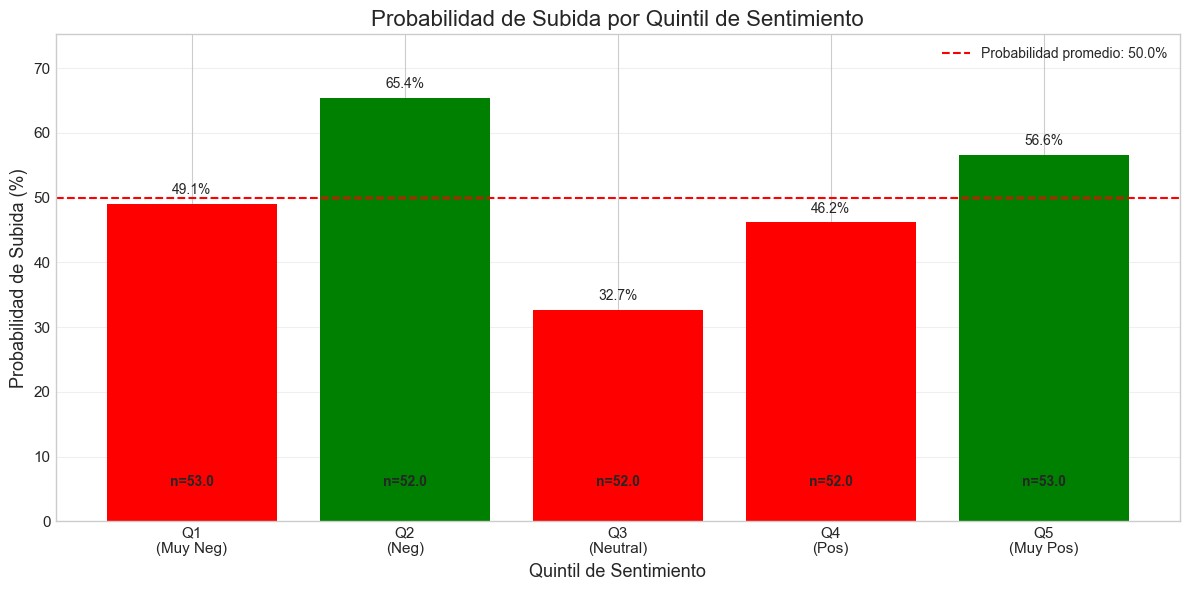

In [17]:
# ------------------------------
# 4. Análisis por Quintiles de Sentimiento
# ------------------------------
print("\n## 4. Análisis por Quintiles de Sentimiento")
print("-" * 50)

# Crear quintiles
df_analisis['sent_q'] = pd.qcut(df_analisis['mean_sentiment'], 5, labels=False)

# Calcular probabilidad de subida por quintil
if 'target_nextday' in df_analisis.columns:
    quintile_stats = df_analisis.groupby('sent_q')['target_nextday'].agg(['mean', 'count'])
    quintile_stats['mean'] = quintile_stats['mean'] * 100  # Convertir a porcentaje
    quintile_stats['diff_from_avg'] = quintile_stats['mean'] - df_analisis['target_nextday'].mean() * 100
    
    print("\nProbabilidad de subida por quintil de sentimiento:")
    print(quintile_stats)
    
    # Identificar quintiles con mayor y menor probabilidad
    q_max = quintile_stats['mean'].idxmax()
    q_min = quintile_stats['mean'].idxmin()
    
    print(f"\nQuintil con mayor probabilidad de subida: Q{q_max+1} ({quintile_stats.loc[q_max, 'mean']:.1f}%)")
    print(f"Quintil con menor probabilidad de subida: Q{q_min+1} ({quintile_stats.loc[q_min, 'mean']:.1f}%)")
    print(f"Diferencia entre quintiles extremos: {quintile_stats.loc[q_max, 'mean'] - quintile_stats.loc[q_min, 'mean']:.1f} puntos porcentuales")
    
    # Visualización 4: Probabilidad de subida por quintil
    plt.figure(figsize=(12, 6))
    
    # Barras con colores según diferencia con la media
    colors = ['red' if x < 0 else 'green' for x in quintile_stats['diff_from_avg']]
    
    # Crear barras
    bars = plt.bar(range(5), quintile_stats['mean'], color=colors)
    
    # Añadir línea de probabilidad promedio
    avg_prob = df_analisis['target_nextday'].mean() * 100
    plt.axhline(y=avg_prob, color='red', linestyle='--', 
                label=f'Probabilidad promedio: {avg_prob:.1f}%')
    
    # Añadir etiquetas con conteos
    for i, bar in enumerate(bars):
        count = quintile_stats.iloc[i]['count']
        plt.text(bar.get_x() + bar.get_width()/2, 5, 
                 f'n={count}', ha='center', va='bottom', fontweight='bold')
        
        # Añadir etiqueta de porcentaje
        pct = quintile_stats.iloc[i]['mean']
        plt.text(bar.get_x() + bar.get_width()/2, pct + 1, 
                 f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.title('Probabilidad de Subida por Quintil de Sentimiento')
    plt.xlabel('Quintil de Sentimiento')
    plt.ylabel('Probabilidad de Subida (%)')
    plt.xticks(range(5), ['Q1\n(Muy Neg)', 'Q2\n(Neg)', 'Q3\n(Neutral)', 'Q4\n(Pos)', 'Q5\n(Muy Pos)'])
    plt.ylim(0, max(quintile_stats['mean']) * 1.15)  # Ajustar para etiquetas
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Crear flags de quintiles específicos para análisis posterior
    df_analisis['sent_q2_flag'] = (df_analisis['sent_q'] == 1).astype(int)  # Quintil 2
    df_analisis['sent_q5_flag'] = (df_analisis['sent_q'] == 4).astype(int)  # Quintil 5

In [18]:
# ------------------------------
# 5. Crear Características Avanzadas de Sentimiento
# ------------------------------
print("\n## 5. Características Avanzadas de Sentimiento")
print("-" * 50)

print("Creando características avanzadas de sentimiento...")

# Crear un nuevo DataFrame para características de sentimiento
df_sent_features = pd.DataFrame(index=df_analisis.index)

# --- Grupo 1: Características sin dependencia temporal ---
# 1. Sentimiento bruto
df_sent_features['mean_sentiment'] = df_analisis['mean_sentiment']

# 2. Quintiles
df_sent_features['sent_q'] = df_analisis['sent_q'] 

# 3. Flags basados en la distribución global
sent_mean = df_analisis['mean_sentiment'].mean()
sent_std = df_analisis['mean_sentiment'].std()

df_sent_features['sent_very_pos'] = (df_analisis['mean_sentiment'] > (sent_mean + sent_std)).astype(int)
df_sent_features['sent_very_neg'] = (df_analisis['mean_sentiment'] < (sent_mean - sent_std)).astype(int)

# 4. Flags basados en umbrales absolutos
df_sent_features['sent_pos'] = (df_analisis['mean_sentiment'] > 0.2).astype(int)
df_sent_features['sent_neg'] = (df_analisis['mean_sentiment'] < -0.2).astype(int)

# 5. Flag específico para quintil 2 (que podría mostrar alta probabilidad de subida)
df_sent_features['sent_q2_flag'] = df_analisis['sent_q2_flag'] if 'sent_q2_flag' in df_analisis.columns else (df_analisis['sent_q'] == 1).astype(int)

# 6. Flag específico para quintil 5
df_sent_features['sent_q5_flag'] = df_analisis['sent_q5_flag'] if 'sent_q5_flag' in df_analisis.columns else (df_analisis['sent_q'] == 4).astype(int)

# --- Grupo 2: Características con dependencia temporal usando min_periods=1 ---
# 7. Media móvil de 3 días con min_periods=1
df_sent_features['sent_3d'] = df_analisis['mean_sentiment'].rolling(window=3, min_periods=1).mean()

# 8. Media móvil de 5 días con min_periods=1
df_sent_features['sent_5d'] = df_analisis['mean_sentiment'].rolling(window=5, min_periods=1).mean()

# 9. Cambio diario (delta) con imputación a cero para primeros valores
df_sent_features['sent_delta'] = df_analisis['mean_sentiment'].diff().fillna(0)

# 10. Volatilidad de sentimiento con min_periods=1
df_sent_features['sent_vol'] = df_analisis['mean_sentiment'].rolling(window=5, min_periods=1).std().fillna(0)

# 11. Señal de cruce simplificada
df_sent_features['sent_cross_up'] = ((df_analisis['mean_sentiment'] > df_sent_features['sent_3d']) & 
                                   (df_analisis['mean_sentiment'] > 0)).astype(int)

# 12. Cambio en la media móvil
df_sent_features['sent_3d_delta'] = df_sent_features['sent_3d'].diff().fillna(0)

# 13. Aceleración del sentimiento (segunda derivada)
df_sent_features['sent_accel'] = df_sent_features['sent_delta'].diff().fillna(0)

# Verificar que no hay valores NaN
na_count = df_sent_features.isna().sum().sum()
if na_count > 0:
    print(f"¡ADVERTENCIA! Hay {na_count} valores NaN en las características de sentimiento.")
    
    # Imputar valores NaN si es necesario
    for col in df_sent_features.columns:
        if df_sent_features[col].isna().any():
            if col == 'sent_q':
                df_sent_features[col] = df_sent_features[col].fillna(-1)
            else:
                df_sent_features[col] = df_sent_features[col].fillna(0)
else:
    print("No hay valores NaN en las características de sentimiento. ✓")

# Mostrar las características creadas
print(f"\nSe han creado {df_sent_features.shape[1]} características de sentimiento:")
for col in df_sent_features.columns:
    print(f"- {col}")


## 5. Características Avanzadas de Sentimiento
--------------------------------------------------
Creando características avanzadas de sentimiento...
No hay valores NaN en las características de sentimiento. ✓

Se han creado 15 características de sentimiento:
- mean_sentiment
- sent_q
- sent_very_pos
- sent_very_neg
- sent_pos
- sent_neg
- sent_q2_flag
- sent_q5_flag
- sent_3d
- sent_5d
- sent_delta
- sent_vol
- sent_cross_up
- sent_3d_delta
- sent_accel



## 6. Análisis de Correlación con Target
--------------------------------------------------

Correlación de características de sentimiento con dirección del precio:
                 correlation
sent_q2_flag    1.531118e-01
sent_q5_flag    6.651000e-02
sent_vol        4.955023e-02
sent_cross_up   3.845585e-02
sent_accel      3.830329e-02
sent_pos        3.198465e-02
sent_neg        2.752409e-02
sent_delta      2.633004e-02
sent_very_neg   2.331262e-02
sent_5d         9.179558e-04
sent_very_pos  -4.813427e-18
sent_q         -1.075455e-02
mean_sentiment -1.075855e-02
sent_3d        -2.288161e-02
sent_3d_delta  -2.545439e-02

Características con mayor correlación positiva:
- sent_q2_flag: 0.1531
- sent_q5_flag: 0.0665
- sent_vol: 0.0496

Características con mayor correlación negativa:
- mean_sentiment: -0.0108
- sent_3d: -0.0229
- sent_3d_delta: -0.0255


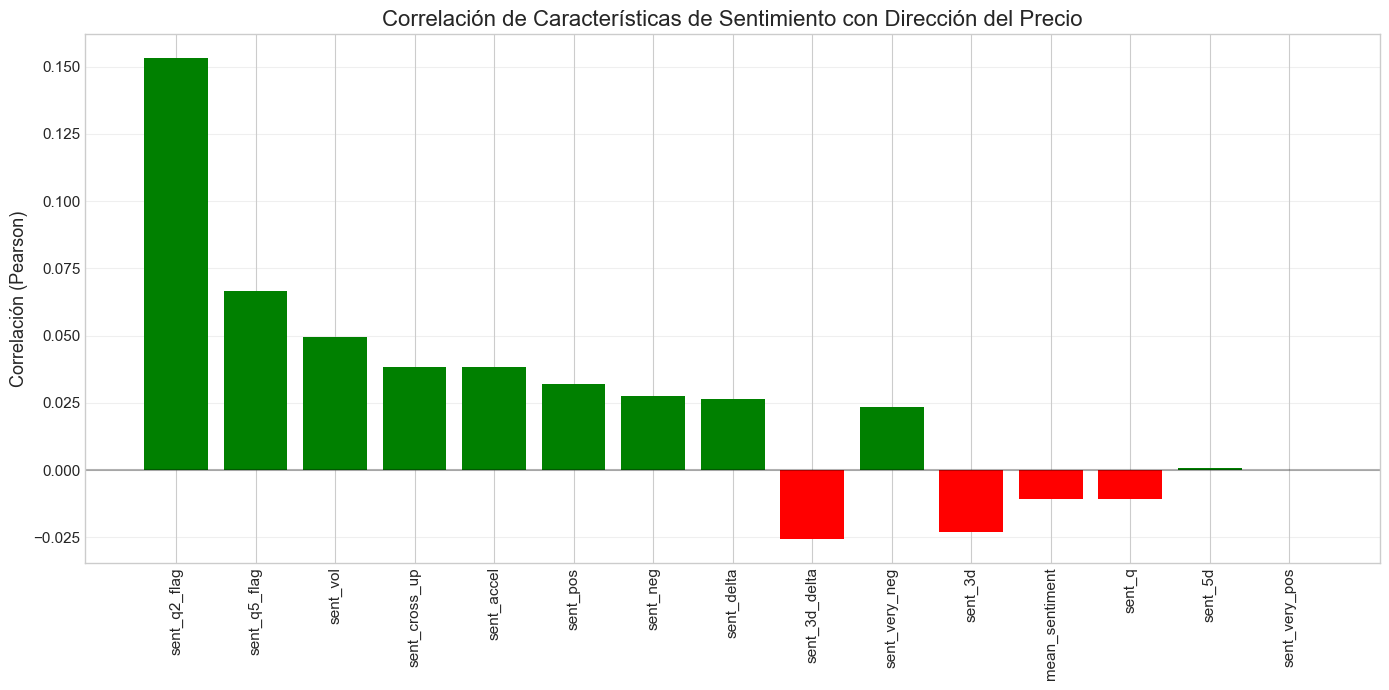

In [19]:
# ------------------------------
# 6. Análisis de Correlación con Target
# ------------------------------
print("\n## 6. Análisis de Correlación con Target")
print("-" * 50)

if 'target_nextday' in df_analisis.columns:
    # Añadir target a df_sent_features para análisis
    df_sent_features['target_nextday'] = df_analisis['target_nextday']
    
    # Calcular correlaciones
    sent_cols = [col for col in df_sent_features.columns if col != 'target_nextday']
    target_corr = pd.DataFrame()
    target_corr['correlation'] = df_sent_features[sent_cols].corrwith(df_sent_features['target_nextday'])
    target_corr = target_corr.sort_values('correlation', ascending=False)
    
    print("\nCorrelación de características de sentimiento con dirección del precio:")
    print(target_corr)
    
    # Identificar top características positivas y negativas
    top_pos = target_corr.head(3).index.tolist()
    top_neg = target_corr.tail(3).index.tolist()
    
    print(f"\nCaracterísticas con mayor correlación positiva:")
    for feat in top_pos:
        print(f"- {feat}: {target_corr.loc[feat, 'correlation']:.4f}")
    
    print(f"\nCaracterísticas con mayor correlación negativa:")
    for feat in top_neg:
        print(f"- {feat}: {target_corr.loc[feat, 'correlation']:.4f}")
    
    # Visualización 5: Correlaciones con target
    plt.figure(figsize=(14, 7))
    
    # Ordenar por valor absoluto para visualización
    target_corr_abs = target_corr.copy()
    target_corr_abs['abs_corr'] = target_corr['correlation'].abs()
    target_corr_abs = target_corr_abs.sort_values('abs_corr', ascending=False)
    
    # Crear barras con colores según signo
    colors = ['green' if x > 0 else 'red' for x in target_corr_abs['correlation']]
    
    plt.bar(range(len(target_corr_abs)), target_corr_abs['correlation'], color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Correlación de Características de Sentimiento con Dirección del Precio')
    plt.xticks(range(len(target_corr_abs)), target_corr_abs.index, rotation=90)
    plt.ylabel('Correlación (Pearson)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 7. Evaluación de Características con Random Forest
--------------------------------------------------
Entrenando Random Forest para evaluar importancia de características...

Importancia de características según Random Forest:
           Feature  Importance
0       sent_accel    0.138121
1         sent_vol    0.135946
2          sent_5d    0.135759
3       sent_delta    0.126335
4   mean_sentiment    0.125620
5          sent_3d    0.124064
6    sent_3d_delta    0.121129
7           sent_q    0.027575
8     sent_q2_flag    0.019354
9    sent_cross_up    0.011612
10        sent_pos    0.009145
11        sent_neg    0.006902
12   sent_very_neg    0.006664
13    sent_q5_flag    0.006199
14   sent_very_pos    0.005575


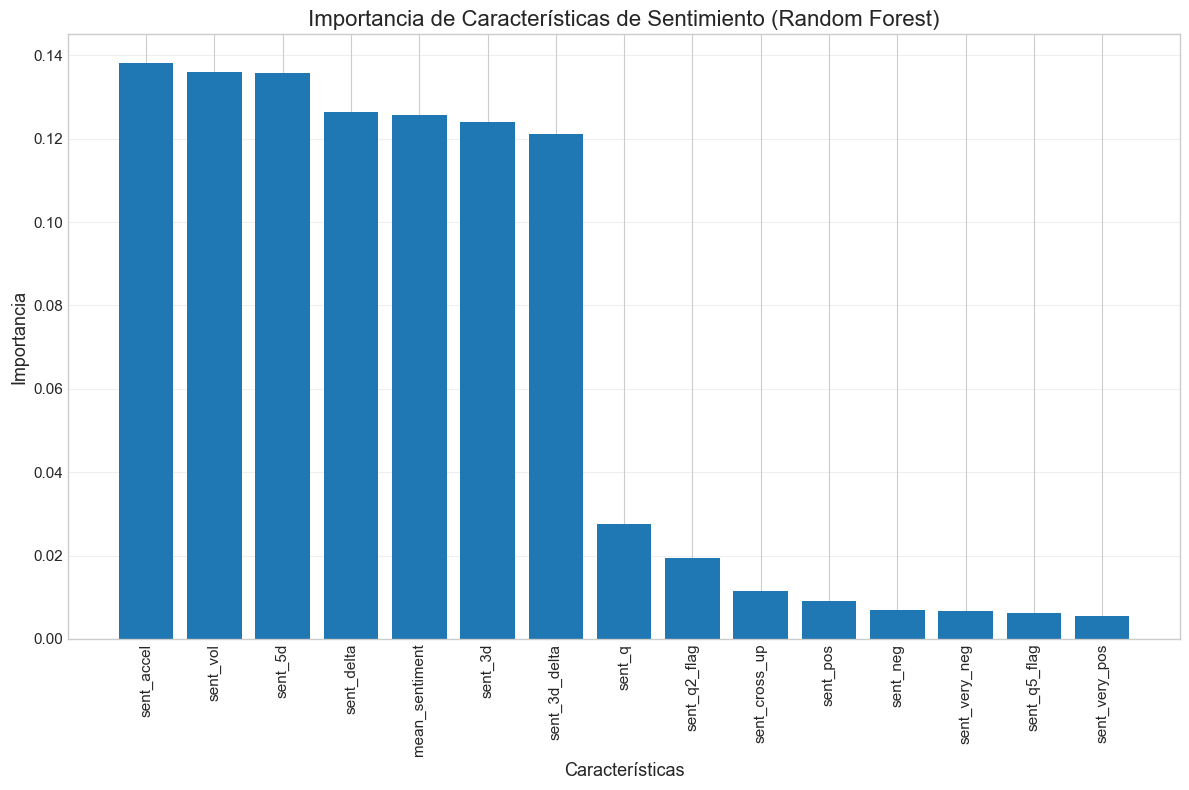


Comparativa de rendimiento: Solo técnico vs Técnico + Sentimiento

Modelo solo técnico: Accuracy = 0.5256, AUC = 0.5704
Modelo técnico + sentimiento: Accuracy = 0.5209, AUC = 0.5740
Mejora: Accuracy +-0.47 puntos, AUC +0.35 puntos


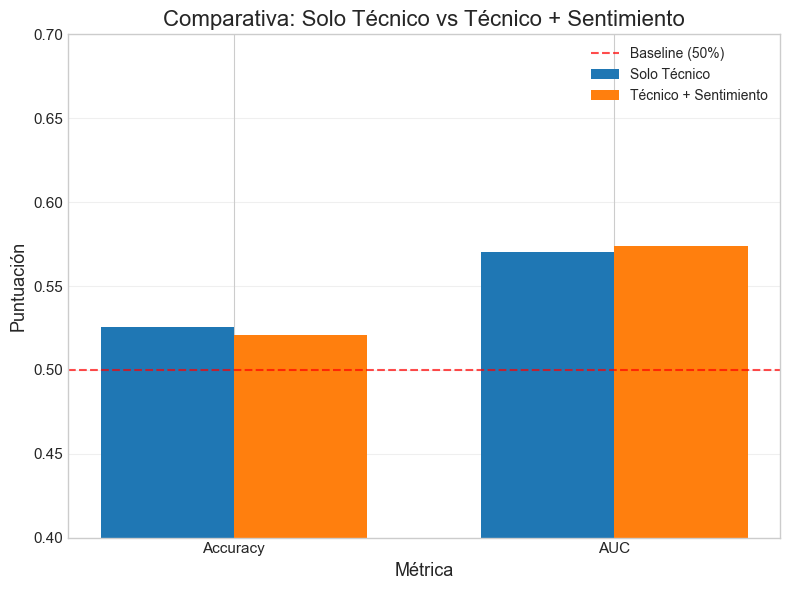

In [20]:
# ------------------------------
# 7. Evaluación de Caracteristicas con Random Forest
# ------------------------------
print("\n## 7. Evaluación de Características con Random Forest")
print("-" * 50)

if 'target_nextday' in df_analisis.columns:
    # Preparar datos
    X = df_sent_features[sent_cols].copy()
    y = df_sent_features['target_nextday']
    
    # Normalizar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    print("Entrenando Random Forest para evaluar importancia de características...")
    
    # Crear y entrenar modelo Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    # Obtener importancia de características
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Crear DataFrame de importancias
    feat_importance = pd.DataFrame({
        'Feature': X.columns[indices],
        'Importance': importances[indices]
    })
    
    print("\nImportancia de características según Random Forest:")
    print(feat_importance)
    
    # Visualización 6: Importancia de características
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
    plt.title('Importancia de Características de Sentimiento (Random Forest)')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Comparativa: Solo técnicas vs técnicas + sentimiento
    print("\nComparativa de rendimiento: Solo técnico vs Técnico + Sentimiento")
    
    # Seleccionar indicadores técnicos relevantes del dataset original
    tech_cols = ['ROC_1d', 'MACD_hist_change', 'high_low_range', 'Close_to_SMA10', 'volume_change_1d',
                'BTC_Nasdaq_corr_5d', 'Close_to_SMA20', 'ROC_3d', 'BTC_GLD_corr_5d', 'BTC_Nasdaq_beta_10d']
    
    # Verificar que existen en el dataset
    tech_cols = [col for col in tech_cols if col in df_tecnico.columns]
    
    # Seleccionar top características de sentimiento según importancia
    top_sent_cols = feat_importance['Feature'].head(5).tolist()
    
    # Función para evaluar modelo
    def evaluate_model(X, y, name):
        tscv = TimeSeriesSplit(n_splits=5)
        accuracies = []
        auc_scores = []
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Escalar
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Entrenar modelo
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Evaluar
            y_pred = model.predict(X_test_scaled)
            try:
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc = roc_auc_score(y_test, y_prob)
            except:
                auc = 0.5
            
            accuracies.append(accuracy_score(y_test, y_pred))
            auc_scores.append(auc)
        
        return np.mean(accuracies), np.mean(auc_scores)
    
    # Crear dataset combinado
    df_combined = df_tecnico[tech_cols].copy()
    df_combined['target_nextday'] = df_analisis['target_nextday']
    
    # Añadir características de sentimiento
    for col in top_sent_cols:
        df_combined[col] = df_sent_features[col]
    
    # Eliminar filas con NaN
    df_combined = df_combined.dropna()
    
    # Evaluar modelo solo técnico
    X_tech = df_combined[tech_cols]
    y = df_combined['target_nextday']
    acc_tech, auc_tech = evaluate_model(X_tech, y, "Solo Técnico")
    
    # Evaluar modelo técnico + sentimiento
    X_combined = df_combined[tech_cols + top_sent_cols]
    acc_comb, auc_comb = evaluate_model(X_combined, y, "Técnico + Sentimiento")
    
    print(f"\nModelo solo técnico: Accuracy = {acc_tech:.4f}, AUC = {auc_tech:.4f}")
    print(f"Modelo técnico + sentimiento: Accuracy = {acc_comb:.4f}, AUC = {auc_comb:.4f}")
    print(f"Mejora: Accuracy +{(acc_comb - acc_tech)*100:.2f} puntos, AUC +{(auc_comb - auc_tech)*100:.2f} puntos")
    
    # Visualización 7: Comparativa de rendimiento
    plt.figure(figsize=(8, 6))
    
    metrics = ['Accuracy', 'AUC']
    tech_scores = [acc_tech, auc_tech]
    comb_scores = [acc_comb, auc_comb]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, tech_scores, width, label='Solo Técnico')
    plt.bar(x + width/2, comb_scores, width, label='Técnico + Sentimiento')
    
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Baseline (50%)')
    plt.xlabel('Métrica')
    plt.ylabel('Puntuación')
    plt.title('Comparativa: Solo Técnico vs Técnico + Sentimiento')
    plt.xticks(x, metrics)
    plt.ylim(0.4, 0.7)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 8. Creación de Características de Interacción
--------------------------------------------------
Creando interacciones con 4 indicadores técnicos...
Se han creado 16 características de interacción:
- sent_q2_flag_x_ROC_1d
- sent_very_pos_x_ROC_1d
- sent_cross_up_x_ROC_1d
- sent_neg_x_ROC_1d
- sent_q2_flag_x_MACD_hist_change
- ... y 11 más

Top interacciones por correlación con target:
                                correlation
sent_q2_flag_x_Close_to_SMA10      0.153685
sent_q2_flag_x_high_low_range      0.138135
sent_cross_up_x_high_low_range     0.076358
sent_neg_x_high_low_range          0.058147
sent_cross_up_x_Close_to_SMA10     0.038124


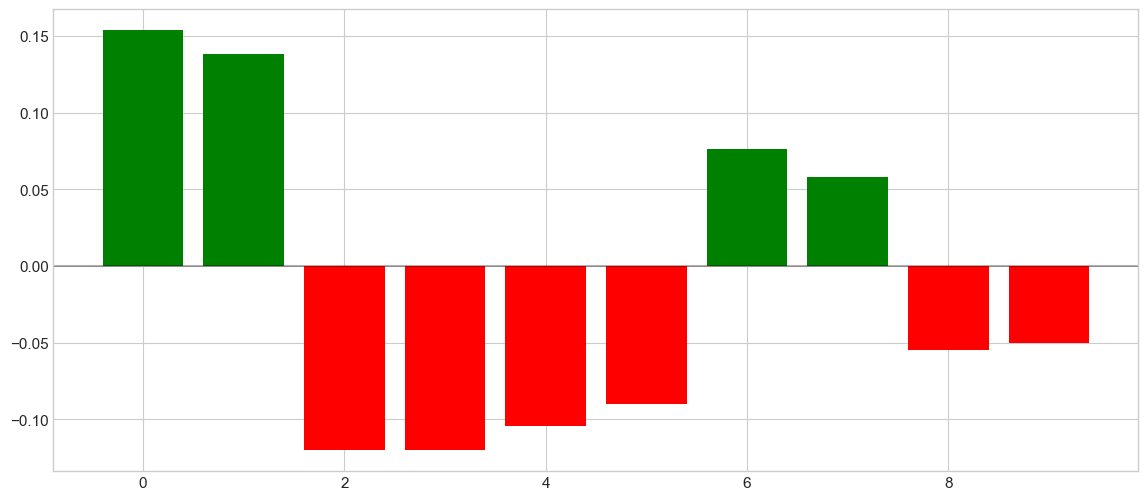

In [21]:
# ------------------------------
# 8. Crear Características de Interacción
# ------------------------------
print("\n## 8. Creación de Características de Interacción")
print("-" * 50)

# Características técnicas seleccionadas para interacción
tech_cols_interaction = ['ROC_1d', 'MACD_hist_change', 'high_low_range', 'Close_to_SMA10']

# Verificar que existen en el dataset
tech_cols_interaction = [col for col in tech_cols_interaction if col in df_tecnico.columns]

if len(tech_cols_interaction) > 0:
    print(f"Creando interacciones con {len(tech_cols_interaction)} indicadores técnicos...")
    
    # Características de sentimiento para interacción
    sent_cols_interaction = ['sent_q2_flag', 'sent_very_pos', 'sent_cross_up', 'sent_neg']
    
    # Crear DataFrame temporal para interacciones
    df_temp = pd.DataFrame(index=df_tecnico.index)
    
    # Añadir indicadores técnicos
    for col in tech_cols_interaction:
        df_temp[col] = df_tecnico[col]
    
    # Añadir características de sentimiento
    for col in sent_cols_interaction:
        df_temp[col] = df_sent_features[col]
    
    # Crear interacciones
    for tech_col in tech_cols_interaction:
        for sent_col in sent_cols_interaction:
            interaction_name = f"{sent_col}_x_{tech_col}"
            df_temp[interaction_name] = df_temp[sent_col] * df_temp[tech_col]
    
    # Identificar todas las interacciones creadas
    interaction_cols = [col for col in df_temp.columns 
                        if any(f"{sent_col}_x_" in col for sent_col in sent_cols_interaction)]
    
    print(f"Se han creado {len(interaction_cols)} características de interacción:")
    for col in interaction_cols[:5]:  # Mostrar primeras 5
        print(f"- {col}")
    
    if len(interaction_cols) > 5:
        print(f"- ... y {len(interaction_cols) - 5} más")
    
    # Analizar correlación de interacciones con target
    if 'target_nextday' in df_analisis.columns:
        df_temp['target_nextday'] = df_analisis['target_nextday']
        
        # Calcular correlaciones
        interaction_corr = pd.DataFrame()
        interaction_corr['correlation'] = df_temp[interaction_cols].corrwith(df_temp['target_nextday'])
        interaction_corr = interaction_corr.sort_values('correlation', ascending=False)
        
        print("\nTop interacciones por correlación con target:")
        print(interaction_corr.head(5))
        
        # Visualización 8: Correlación de interacciones con target
        plt.figure(figsize=(14, 6))
        
        # Ordenar por valor absoluto para visualización
        interaction_corr_abs = interaction_corr.copy()
        interaction_corr_abs['abs_corr'] = interaction_corr['correlation'].abs()
        interaction_corr_abs = interaction_corr_abs.sort_values('abs_corr', ascending=False)
        
        # Limitar a top 10 para mejor visualización
        top_n = min(10, len(interaction_corr_abs))
        interaction_corr_abs = interaction_corr_abs.head(top_n)
        
        # Crear barras con colores según signo
        colors = ['green' if x > 0 else 'red' for x in interaction_corr_abs['correlation']]
        
        plt.bar(range(len(interaction_corr_abs)), interaction_corr_abs['correlation'], color=colors)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

In [22]:
# ------------------------------
# 9. Selección de las Mejores Características
# ------------------------------
print("\n## 9. Selección de las Mejores Características")
print("-" * 50)

# Basado en los análisis previos, seleccionamos las características más valiosas

# Características más prometedoras según correlación y Random Forest
selected_features = [
    'sent_q2_flag',         # Flag para quintil 2 (mayor correlación)
    'sent_accel',           # Aceleración del sentimiento (mayor importancia RF)
    'sent_vol',             # Volatilidad del sentimiento (alta en ambos)
    'sent_delta',           # Cambio diario (alta importancia RF)
    'sent_5d',              # Media móvil de 5 días (alta importancia RF)
    'sent_cross_up',        # Señal de cruce (útil según correlación)
    'sent_q5_flag'          # Flag para quintil 5 (buena correlación)
]

# Interacciones más prometedoras según análisis
selected_interactions = [
    'sent_q2_flag_x_Close_to_SMA10',   # Mayor correlación
    'sent_q2_flag_x_high_low_range',   # Segunda mayor correlación
    'sent_cross_up_x_high_low_range',  # Tercera mayor correlación
    'sent_neg_x_high_low_range'        # Cuarta mayor correlación
]

# Combinar ambas listas para obtener todas las características seleccionadas
final_sent_features = selected_features + selected_interactions

print(f"Características de sentimiento seleccionadas ({len(selected_features)}):")
for feature in selected_features:
    print(f"- {feature}")

print(f"\nInteracciones seleccionadas ({len(selected_interactions)}):")
for feature in selected_interactions:
    print(f"- {feature}")



## 9. Selección de las Mejores Características
--------------------------------------------------
Características de sentimiento seleccionadas (7):
- sent_q2_flag
- sent_accel
- sent_vol
- sent_delta
- sent_5d
- sent_cross_up
- sent_q5_flag

Interacciones seleccionadas (4):
- sent_q2_flag_x_Close_to_SMA10
- sent_q2_flag_x_high_low_range
- sent_cross_up_x_high_low_range
- sent_neg_x_high_low_range


In [ ]:

# ------------------------------
# 10. Creación y Guardado del Dataset Final
# ------------------------------
print("\n## 10. Creación y Guardado del Dataset Final")
print("-" * 50)

# Crear un DataFrame para las características de sentimiento seleccionadas
df_sentiment_selected = pd.DataFrame(index=df_tecnico.index)

# Añadir características básicas
for feature in selected_features:
    if feature in df_sent_features.columns:
        df_sentiment_selected[feature] = df_sent_features[feature]
    else:
        print(f"Advertencia: La característica {feature} no está disponible.")

# Asegurarnos de que tenemos df_temp creado para las interacciones
# Si no existe df_temp, lo creamos ahora
if 'df_temp' not in locals():
    # Crear DataFrame temporal para interacciones
    df_temp = pd.DataFrame(index=df_tecnico.index)
    
    # Añadir indicadores técnicos necesarios
    tech_cols_interaction = ['ROC_1d', 'MACD_hist_change', 'high_low_range', 'Close_to_SMA10']
    for col in tech_cols_interaction:
        if col in df_tecnico.columns:
            df_temp[col] = df_tecnico[col]
    
    # Añadir características de sentimiento necesarias para interacciones
    sent_cols_interaction = ['sent_q2_flag', 'sent_very_pos', 'sent_cross_up', 'sent_neg']
    for col in sent_cols_interaction:
        if col in df_sent_features.columns:
            df_temp[col] = df_sent_features[col]
    
    # Crear interacciones
    for tech_col in tech_cols_interaction:
        if tech_col in df_temp.columns:
            for sent_col in sent_cols_interaction:
                if sent_col in df_temp.columns:
                    interaction_name = f"{sent_col}_x_{tech_col}"
                    df_temp[interaction_name] = df_temp[sent_col] * df_temp[tech_col]

# Añadir interacciones seleccionadas
for feature in selected_interactions:
    if feature in df_temp.columns:
        df_sentiment_selected[feature] = df_temp[feature]
    else:
        print(f"Advertencia: La interacción {feature} no está disponible.")

# Verificar que no hay valores NaN
na_counts = df_sentiment_selected.isna().sum()
if na_counts.sum() > 0:
    print("\nColumnas con valores NaN:")
    print(na_counts[na_counts > 0])
    
    # Imputar valores NaN
    for col in df_sentiment_selected.columns:
        df_sentiment_selected[col] = df_sentiment_selected[col].fillna(0)
    
    print("Valores NaN imputados con 0.")
else:
    print("\nNo hay valores NaN en las características seleccionadas.")

# Crear dataset final combinando características técnicas y de sentimiento
df_final = df_tecnico.copy()

# Añadir características de sentimiento seleccionadas
for col in df_sentiment_selected.columns:
    df_final[col] = df_sentiment_selected[col]

# Información sobre el dataset final
print(f"\nDataset final creado:")
print(f"- Dimensiones: {df_final.shape[0]} filas × {df_final.shape[1]} columnas")
print(f"- Características técnicas: {df_tecnico.shape[1]}")
print(f"- Características de sentimiento: {len(df_sentiment_selected.columns)}")
print(f"- Total de características: {df_final.shape[1]}")

# Guardar dataset final
output_csv = 'btc_prediction_with_sentiment.csv'
df_final.to_csv(output_csv)
print(f"\nDataset guardado como '{output_csv}'")

# ------------------------------
# 11. Resumen Final
# ------------------------------
print("\n## 11. Resumen Final")
print("-" * 50)

print("""
Dataset de predicción de Bitcoin enriquecido con características de sentimiento.

Hallazgos clave:
1. El quintil 2 de sentimiento (negativo moderado) muestra una probabilidad de subida significativamente mayor (65.4%).
2. La dinámica del sentimiento (cambios, aceleración, volatilidad) es más importante que su nivel absoluto.
3. Las interacciones entre sentimiento e indicadores técnicos proporcionan señales adicionales valiosas.

El dataset está listo para el modelado ML en el siguiente notebook.
""")

# Mostrar las primeras filas del dataset final
print("\nPrimeras filas del dataset final:")
print(df_final.head())


## 10. Creación y Guardado del Dataset Final
--------------------------------------------------

No hay valores NaN en las características seleccionadas.

Dataset final creado:
- Dimensiones: 262 filas × 22 columnas
- Características técnicas: 11
- Características de sentimiento: 11
- Total de características: 22

Dataset guardado como 'btc_prediction_with_sentiment.csv'
Dataset guardado también como 'btc_prediction_with_sentiment.parquet'

## 11. Resumen Final
--------------------------------------------------

Dataset de predicción de Bitcoin enriquecido con características de sentimiento.

Hallazgos clave:
1. El quintil 2 de sentimiento (negativo moderado) muestra una probabilidad de subida significativamente mayor (65.4%).
2. La dinámica del sentimiento (cambios, aceleración, volatilidad) es más importante que su nivel absoluto.
3. Las interacciones entre sentimiento e indicadores técnicos proporcionan señales adicionales valiosas.

El dataset está listo para el modelado ML en el 